In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


In [2]:
# Step 1: Load the sales data into a Pandas DataFrame
df = pd.read_csv("D:/internship/Retail_Store_Sales_Forecasting/data/retail_sales_mock_data.csv")  

In [3]:
df.head()

,Date,SalesAmount,Promotion,HolidayMonth
0,2020-01-01,12248,0,0
1,2020-02-01,11712,0,0
2,2020-03-01,11423,0,0
3,2020-04-01,14030,1,0
4,2020-05-01,9082,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          48 non-null     object
 1   SalesAmount   48 non-null     int64 
 2   Promotion     48 non-null     int64 
 3   HolidayMonth  48 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.6+ KB


In [5]:
df.describe()

,SalesAmount,Promotion,HolidayMonth
count,48.000000,48.000000,48.000000
mean,11829.854167,0.125000,0.083333
std,2436.051837,0.334219,0.279310
min,8445.000000,0.000000,0.000000
25%,10369.000000,0.000000,0.000000
50%,11424.000000,0.000000,0.000000
75%,12799.250000,0.000000,0.000000
max,19753.000000,1.000000,1.000000


In [6]:
# Step 2: Convert the date column to datetime 
df['Date'] = pd.to_datetime(df['Date'])  

In [7]:
# Set 'Date' as the index
df = df.set_index('Date')


In [8]:
# Sort by date
df = df.sort_index() # Ensure chronological order


In [9]:
df.isnull().sum()

SalesAmount     0
Promotion       0
HolidayMonth    0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
duplicates = df[df.duplicated()]
print(duplicates) 

Empty DataFrame
Columns: [SalesAmount, Promotion, HolidayMonth]
Index: []


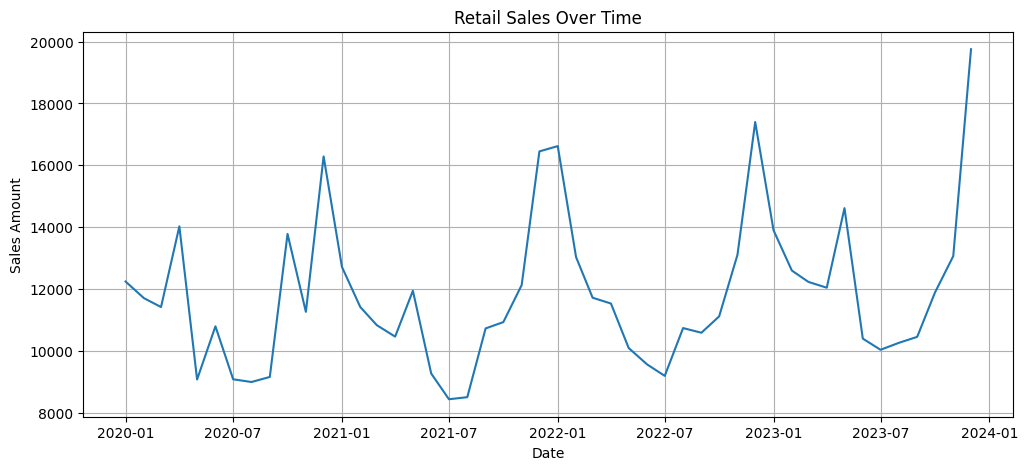

In [12]:
# Step 4: Plot the sales over time
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x=df.index, y='SalesAmount')
plt.title("Retail Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.grid(True)
plt.show()

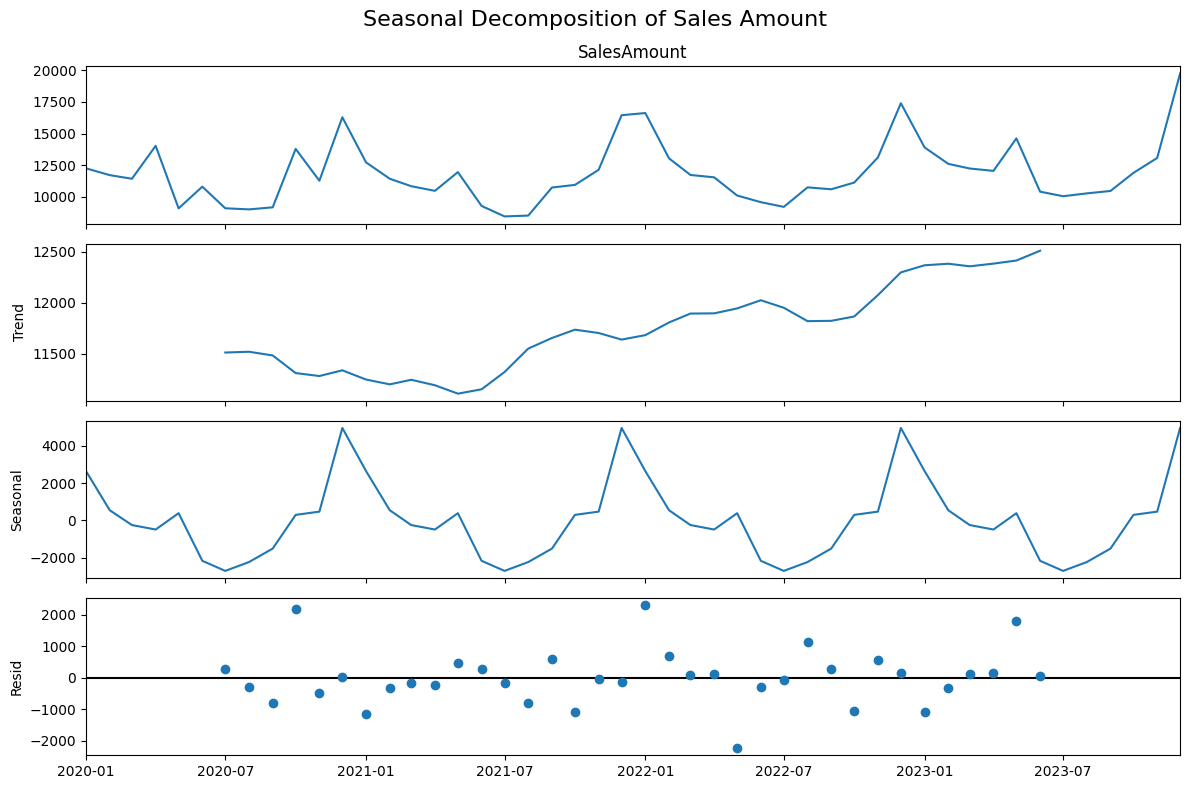

In [13]:
# Step 5: Decompose the time series
decomposition = seasonal_decompose(df['SalesAmount'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Seasonal Decomposition of Sales Amount", fontsize=16)
plt.tight_layout()
plt.show()


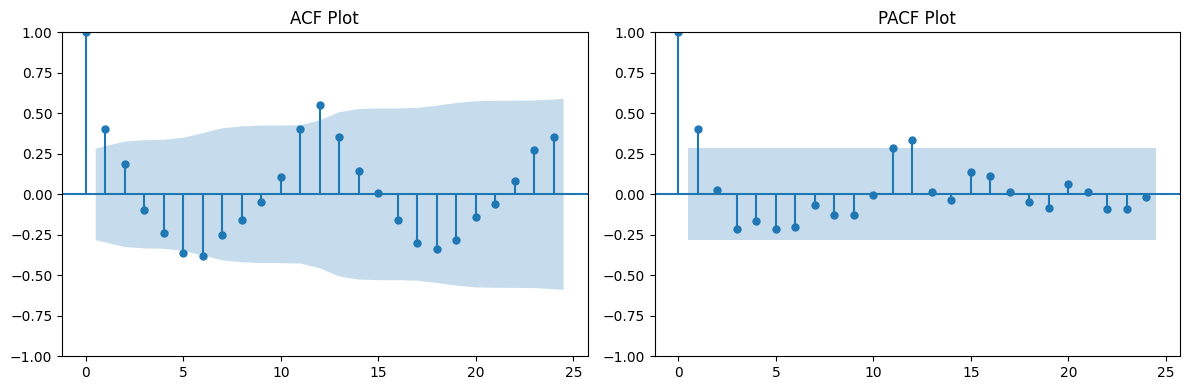

In [14]:
# Step 6: Plot ACF and PACF
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(df['SalesAmount'], lags=24, ax=plt.gca())
plt.title("ACF Plot")

plt.subplot(1, 2, 2)
plot_pacf(df['SalesAmount'], lags=24, ax=plt.gca(), method='ywm')
plt.title("PACF Plot")

plt.tight_layout()
plt.show()


In [15]:
# Step 7: Perform Dickey-Fuller test
result = adfuller(df['SalesAmount'])
print("\nDickey-Fuller Test Results:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value {key}: {value}")

if result[1] < 0.05:
    print("✅ The time series is stationary.")
else:
    print("⚠️ The time series is **not** stationary.")


Dickey-Fuller Test Results:
ADF Statistic: -0.9906636935452957
p-value: 0.7566542548537369
Critical Value 1%: -3.6209175221605827
Critical Value 5%: -2.9435394610388332
Critical Value 10%: -2.6104002410518627
⚠️ The time series is **not** stationary.


# Differencing (for stationarity) #

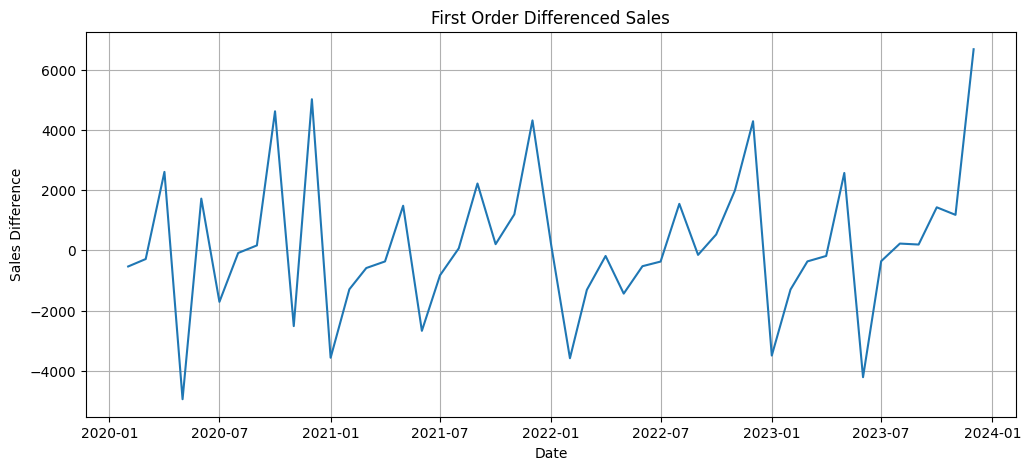

In [16]:
# First order differencing
df['Sales_diff1'] = df['SalesAmount'].diff()

# Drop the first NaN
df_diff = df.dropna(subset=['Sales_diff1'])

# Plot the differenced series
plt.figure(figsize=(12, 5))
plt.plot(df_diff.index, df_diff['Sales_diff1'])
plt.title("First Order Differenced Sales")
plt.xlabel("Date")
plt.ylabel("Sales Difference")
plt.grid(True)
plt.show()

In [17]:
# Check stationarity again
result_diff = adfuller(df_diff['Sales_diff1'])
print("\nDickey-Fuller Test After Differencing:")
print(f"ADF Statistic: {result_diff[0]}")
print(f"p-value: {result_diff[1]}")
for key, value in result_diff[4].items():
    print(f"Critical Value {key}: {value}")

if result_diff[1] < 0.05:
    print("✅ The differenced series is stationary.")
else:
    print("⚠️ The series still might not be stationary.")


Dickey-Fuller Test After Differencing:
ADF Statistic: -6.479880127190435
p-value: 1.303026479151685e-08
Critical Value 1%: -3.626651907578875
Critical Value 5%: -2.9459512825788754
Critical Value 10%: -2.6116707716049383
✅ The differenced series is stationary.


# Model Selection (ARIMA/SARIMA) #

In [18]:
from pmdarima import auto_arima

# Use auto_arima to suggest optimal (p,d,q)
stepwise_model = auto_arima(df['SalesAmount'],
                            start_p=0, start_q=0,
                            max_p=5, max_q=5,
                            seasonal=True, m=12,  # Monthly seasonality
                            d=None, D=1,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.summary())

c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=638.192, Time=0.86 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=639.557, Time=0.08 sec


c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=637.978, Time=0.51 sec


c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=634.756, Time=1.63 sec


c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,0)[12]             : AIC=639.351, Time=0.95 sec


c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=641.648, Time=0.90 sec


c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=639.142, Time=3.45 sec


c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=637.692, Time=2.50 sec


c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=637.291, Time=1.77 sec


c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=639.183, Time=6.25 sec


c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=636.598, Time=0.61 sec


c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=636.881, Time=2.30 sec


c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=638.138, Time=1.12 sec


c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=638.275, Time=1.14 sec


c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=638.956, Time=3.51 sec


c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12]             : AIC=641.372, Time=0.85 sec

Best model:  ARIMA(0,0,1)(0,1,1)[12] intercept
Total fit time: 28.659 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -313.378
Date:                            Tue, 10 Jun 2025   AIC                            634.756
Time:                                    20:45:06   BIC                            641.090
Sample:                                01-01-2020   HQIC                           636.967
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

# Fit ARIMA/SARIMA Model #

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use the best model parameters from auto_arima
model = SARIMAX(df['SalesAmount'],
                order=(0,0,1),              # Replace with your best (p,d,q)
                seasonal_order=(0,1,1,12),  # Replace with your best (P,D,Q,s)
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(results.summary())

c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                        SalesAmount   No. Observations:                   48
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -191.135
Date:                            Tue, 10 Jun 2025   AIC                            388.269
Time:                                    20:53:33   BIC                            391.543
Sample:                                01-01-2020   HQIC                           389.040
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2182      1.039      0.210      0.834      -1.817       2.254
ma.S.L12      -0.1687      0.244   

# Forecasting #

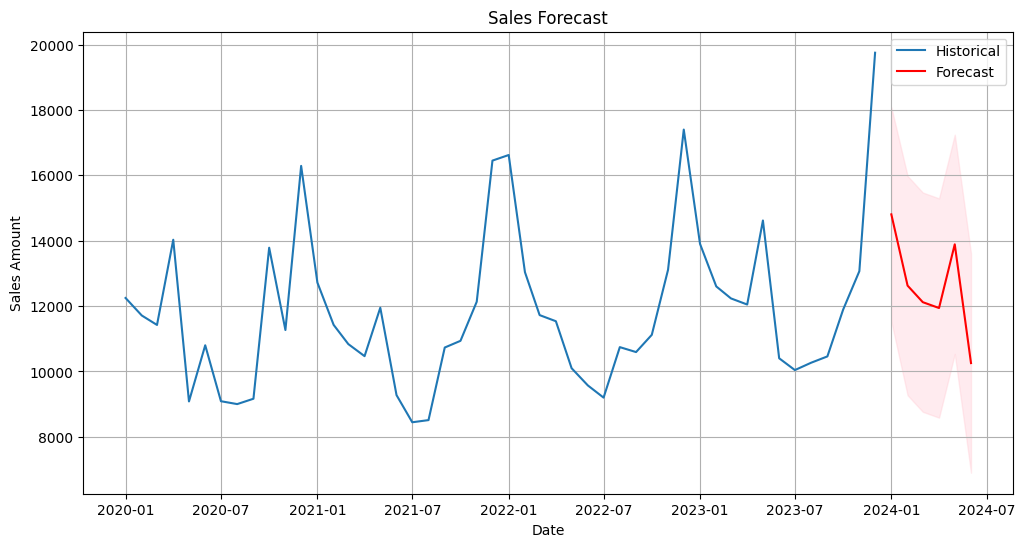

In [22]:
n_forecast = 6  # Forecast next 6 months
forecast = results.get_forecast(steps=n_forecast)
forecast_df = forecast.conf_int()
forecast_df['Forecast'] = forecast.predicted_mean
forecast_df.index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=n_forecast, freq='MS')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['SalesAmount'], label='Historical')
plt.plot(forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df.index,
                 forecast_df['lower SalesAmount'],
                 forecast_df['upper SalesAmount'], color='pink', alpha=0.3)

plt.title("Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.grid(True)
plt.show()

# Alternative: Using Prophet (by Meta/Facebook) #

c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
20:59:32 - cmdstanpy - INFO - Chain [1] start processing
20:59:35 - cmdstanpy - INFO - Chain [1] done processing


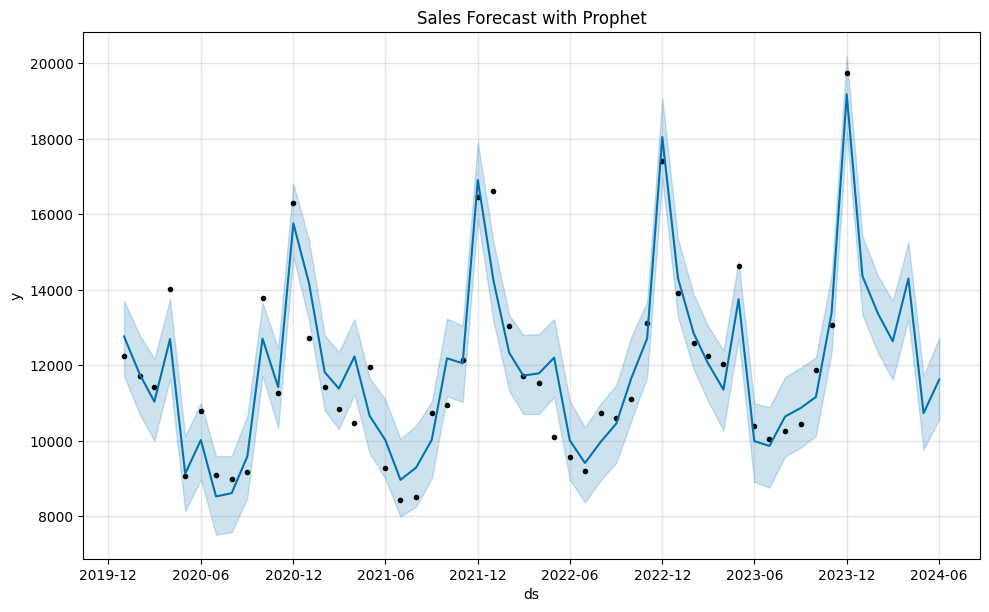

In [23]:
from prophet import Prophet

# Prepare data
df_prophet = df.reset_index()[['Date', 'SalesAmount']].rename(columns={'Date': 'ds', 'SalesAmount': 'y'})

# Fit model
model = Prophet()
model.fit(df_prophet)

# Create future dates
future = model.make_future_dataframe(periods=6, freq='MS')
forecast = model.predict(future)

# Plot
fig = model.plot(forecast)
plt.title("Sales Forecast with Prophet")
plt.show()